# Amplitude and Phase

The goal of this notebook is to read SLC (Single Look Complex) data and convert to amplitude and phase images.


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rio
import xarray as xr
from pathlib import Path
import os
import cmcrameri as cmc
import snaphu


# Load the data

In [2]:
user = Path.home().name
path = rf"/mnt/c/Users/{user}/mrs-data/multilooking_and_filtering"
filename_origin = "S1A_IW_SLC__1SDV_20230129T033452_20230129T033519_046993_05A2FE_BE0B_Orb_Stack_IW3_ifg_deb_dinsar_ML_flt_Cnv.tif"
filename_lowcoh = "S1A_IW_SLC__1SDV_20230129T033452_20230129T033519_046993_05A2FE_BE0B_Orb_Stack_IW3_ifg_deb_dinsar_ML_flt_lowcohFilt_TC.tif"

src = Path(path)
path_origin = src / filename_origin
path_lowcoh = src / filename_lowcoh

# Open the data
origin = xr.open_dataarray(path_origin)
lowcoh = xr.open_dataarray(path_lowcoh)

# Set colormaps
cmap_cyc, cmap_cyc_r = "cmc.romaO", "cmc.romaO_r"
cmap_lin, cmap_lin_r = "cmc.roma", "cmc.roma_r"

# Create a mask for the areas which have no data
mask = origin.sel(band=2).where(origin.sel(band=2) == 0, True, False).astype(bool)
mask_lowcoh = lowcoh.squeeze().where(lowcoh.squeeze() == 0).astype(bool)

Warning 1: TIFFFetchNormalTag:Incorrect count for "GeoTiePoints"; tag ignored
/home/npikall/miniconda3/envs/07_amplitude-and-phase/lib/python3.10/site-packages/rioxarray/_io.py:1136: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


# Structure


1) computing the unwrapping using snaphu-py package. 
2) Mask the image excluding coherence values lower than 0.3 or 0.4 (we can play around), so that we show what coherence is useful for. 
3) Applying the equation for retrieving the displacement map (directly in python) 
4) We need to geocode the image from radar geometry to latlon (This last step needs to be assessed if we can do that on python)

$$
d = - \frac{\lambda}{4 \cdot \pi} \cdot \Delta \phi_d
$$

where:
- $\lambda = 0.056$ for Sentinel-1
- $\Delta \phi_d$ is the unwrapped image

# Compare Source and expected output

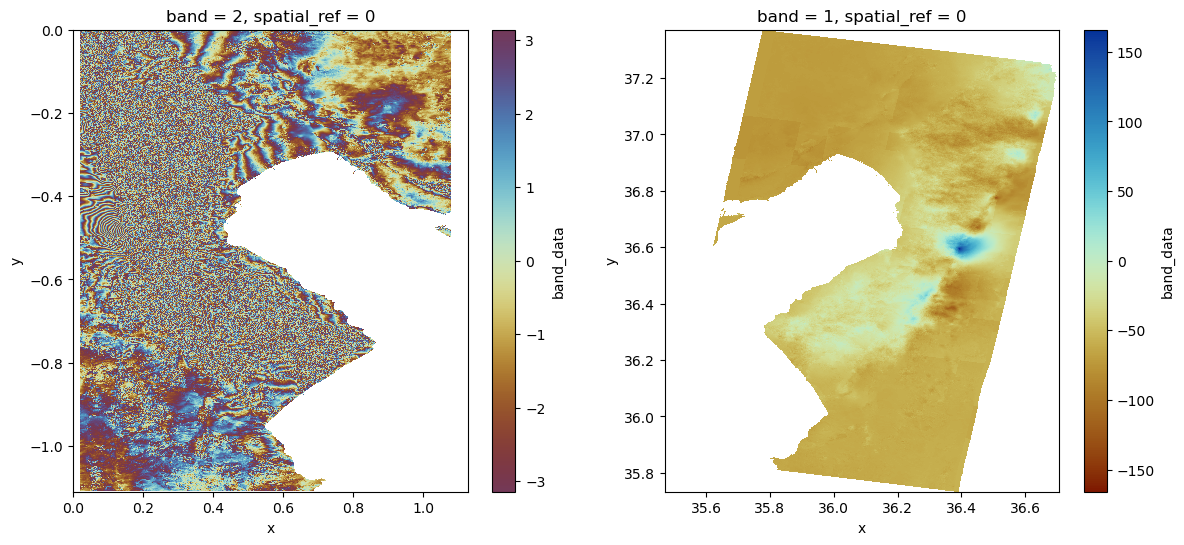

In [3]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
origin.sel(band=2).where(mask == True).plot.imshow(ax=axs[0], cmap=cmap_cyc)
lowcoh.squeeze().where(mask_lowcoh == True).plot.imshow(ax=axs[1], cmap=cmap_lin)
plt.show()

# Snaphu phase unwrapping
## Standard procedure on a small subset of the data

- band_1 -> Intensity_ifg_VV_29Jan2023_10Feb2023 
- band_2 -> Phase_ifg_VV_29Jan2023_10Feb2023
- band_3 -> coh_IW3_VV_29Jan2023_10Feb2023

In [4]:
def unwrap_data(data:xr.DataArray,
                mask:xr.DataArray=True,
                phase_band:int=2,
                intensity_band:int=1,
                coherence_band:int=3,
                mask_nodata_value:int=0,
                coh_low_threshold:float=None,
                coh_high_threshold:float=None,
                **kwargs) -> xr.DataArray:
    """
    Unwraps the phase data using the snaphu algorithm

    :param data: xarray DataArray with phase, intensity and coherence bands
    :type data: xr.DataArray
    :param mask: xarray DataArray with mask values
    :type mask: xr.DataArray | bool
    :param phase_band: Band number of the phase data
    :type phase_band: int
    :param intensity_band: Band number of the intensity data
    :type intensity_band: int
    :param coherence_band: Band number of the coherence data
    :type coherence_band: int
    :param mask_nodata_value: Value of the no data pixels in the mask
    :param coh_low_threshold: Lower threshold for the coherence values
    :param coh_high_threshold: Higher threshold for the coherence values

    :return: xarray DataArray with the unwrapped phase
    :rtype: xr.DataArray
    """

    # Create a mask for the areas which have a lot of no data
    if mask is True:
        mask= data.sel(band=phase_band).where(data.sel(band=phase_band) == mask_nodata_value, True, False).astype(bool)
        # data = data.where(mask == True)

    elif type(mask) == xr.DataArray:
        mask = mask
        # data = data.where(mask == True)
    
    if coh_low_threshold is not None:
        coh = data.sel(band=coherence_band)
        coh_mask = coh.where(coh >= coh_low_threshold, False, True).astype(bool)
        mask = mask & coh_mask
        # return coh_mask, mask_nodata
    elif coh_high_threshold is not None:
        coh = data.sel(band=coherence_band)
        coh_mask = coh.where(coh <= coh_high_threshold, False, True).astype(bool)
        mask = mask & coh_mask
    
    # Apply the mask to the data
    data = data.where(mask == True)

    # Set the intensity and phase from the bands
    intensity = data.sel(band=intensity_band)
    phase = data.sel(band=phase_band)
    coh = data.sel(band=coherence_band)

    # Convert Polar Coordinates to Cartesian Coordinates (snaphu requires complex numbers)
    x = np.sqrt(intensity) * np.cos(phase)
    y = np.sqrt(intensity) * np.sin(phase)
    igram = x + y * 1j

    # Unwrap the phase 
    unw, conncomp = snaphu.unwrap(igram, coh, nlooks=1.0, cost="smooth", init="mcf", mask=mask, **kwargs)

    # Build xarray Dataset with the unwrapped phase
    unw_da = xr.DataArray(unw, coords=phase.coords, dims=phase.dims)
    #conncomp_da = xr.DataArray(conncomp, coords=phase.coords, dims=phase.dims)

    # Mask the unwrapped phase
    unw_da = unw_da.where(mask == True)
    return unw_da

In [5]:
# Select a subset of the data
subset = origin.isel(x=slice(0,500), y=slice(0,500))

unwrapped_subset = unwrap_data(subset)


snaphu v2.0.7
23 parameters input from file /tmp/tmpz_imm5iv/snaphu.config.fo6_xd1_.txt (23 lines total)
Reading wrapped phase from file /tmp/tmpz_imm5iv/snaphu.igram.7883bsmx.c8
Reading byte mask from file /tmp/tmpz_imm5iv/snaphu.mask.znkde5ju.u1
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmpz_imm5iv/snaphu.corr.y5w7o0_9.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 2
Flow increment: 1  (Total improvements: 0)
Found 1 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmpz_imm5iv/snaphu.conncomp.ascewo8s.u4 as 4-byte unsigned ints
Maximum flow on network: 1
Total solution cost: 13289957
Integrating phase
Writing output to file /tmp/tmpz_imm5iv/snaphu.unw.iu3iuk39.f4
Program snaphu done
Elapsed processor time:   0:00:04.26
Elapsed wall clock time:  0:00:04


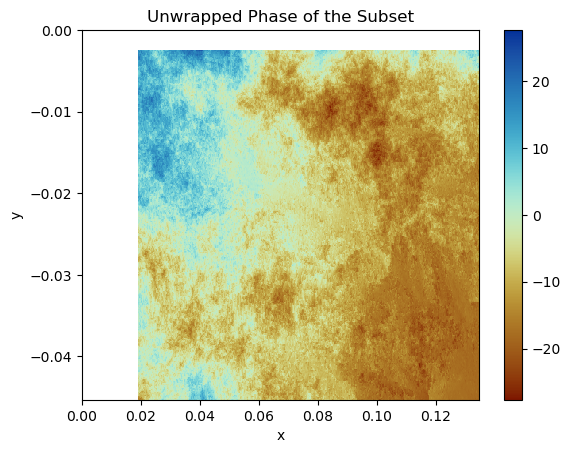

In [6]:
unwrapped_subset.plot.imshow(cmap=cmap_lin).axes.set_title("Unwrapped Phase of the Subset")
plt.show()

## Applying equation for displacement map
$
d = - \frac{\lambda}{4 \cdot \pi} \cdot \Delta \phi_d
$

where:
- $\lambda = 0.056$ for Sentinel-1
- $\Delta \phi_d$ is the unwrapped image

In [7]:
def displacement(unw, lambda_val:float=0.056) -> xr.DataArray:
    """
    Calculates the displacement from the unwrapped phase

    :param unw: xarray DataArray with the unwrapped phase
    :type unw: xr.DataArray
    :param lambda_val: Wavelength of the radar signal
    :type lambda_val: float

    :return: xarray DataArray with the displacement
    :rtype: xr.DataArray
    """
    disp = unw * - lambda_val / (4 * np.pi)
    return disp

disp_map = displacement(unwrapped_subset)

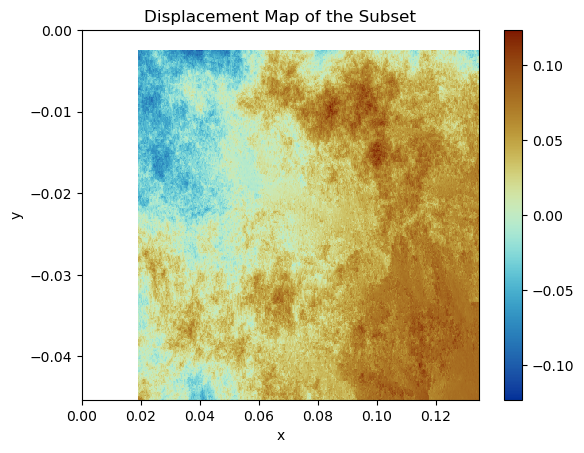

In [8]:
disp_map.plot.imshow(cmap=cmap_lin_r).axes.set_title("Displacement Map of the Subset")
plt.show()

## excluding coherence values lower than 0.3 or 0.4

In [9]:
unwrapped_filtered = unwrap_data(subset, coh_high_threshold=0.3)


snaphu v2.0.7
23 parameters input from file /tmp/tmpzxxfkekb/snaphu.config._wo12uyh.txt (23 lines total)
Reading wrapped phase from file /tmp/tmpzxxfkekb/snaphu.igram.kcudkmeg.c8
Reading byte mask from file /tmp/tmpzxxfkekb/snaphu.mask.ad7hoj0p.u1
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmpzxxfkekb/snaphu.corr.ozjtd73e.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 6
Flow increment: 1  (Total improvements: 0)
Found 1413 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmpzxxfkekb/snaphu.conncomp.o5figgsr.u4 as 4-byte unsigned ints
Maximum flow on network: 1
Total solution cost: 3618649
Integrating phase
Writing output to file /tmp/tmpzxxfkekb/snaphu.unw.55bosh0o.f4
Program snaphu done
Elapsed processor time:   0:00:07.02
Elapsed wall clock time:  0:00:07


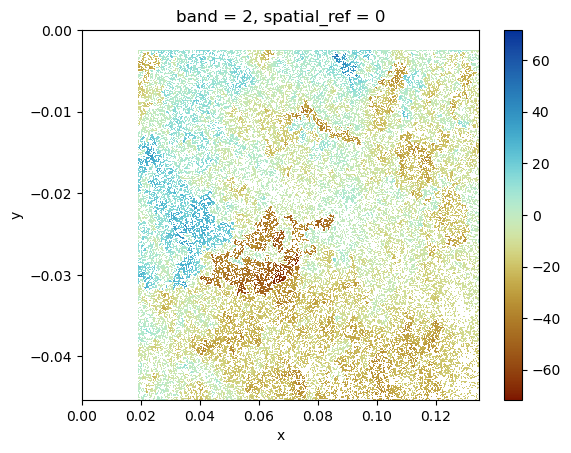

In [10]:
unwrapped_filtered.plot.imshow(cmap=cmap_lin)

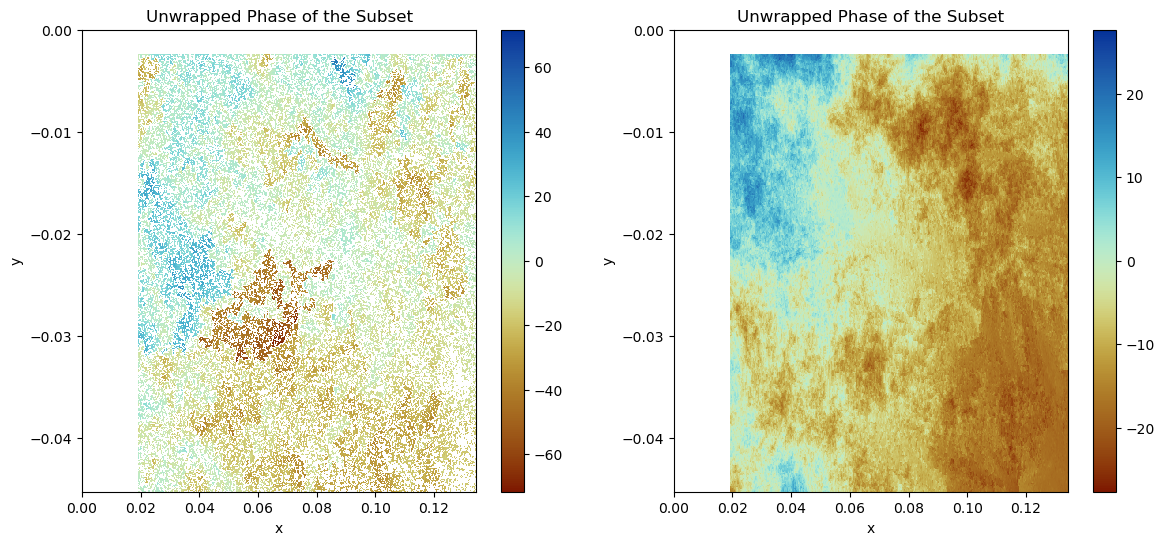

In [11]:
# Plot the unwrapped phase
fig, axs = plt.subplots(1,2, figsize=(14,6))
unwrapped_filtered.plot.imshow(ax=axs[0], cmap=cmap_lin).axes.set_title("Unwrapped Phase of the Subset")
unwrapped_subset.plot.imshow(ax=axs[1], cmap=cmap_lin).axes.set_title("Unwrapped Phase of the Subset")
plt.show()

In [19]:
unwrapped_origin = unwrap_data(origin, coh_high_threshold=0.3, ntiles=(20,30), tile_overlap=10)


snaphu v2.0.7
24 parameters input from file /tmp/tmp0qtu3pvu/snaphu.config.cpv7xmvb.txt (24 lines total)
Starting first-round tile-mode unwrapping
Creating temporary directory /tmp/tmp0qtu3pvu/snaphu_tiles_65815
Unwrapping tile at row 0, column 0
Reading wrapped phase from file /tmp/tmp0qtu3pvu/snaphu.igram.8lsa93e9.c8
Reading byte mask from file /tmp/tmp0qtu3pvu/snaphu.mask.0463bltf.u1
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmp0qtu3pvu/snaphu.corr.9wgasm5l.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 4
Flow increment: 1  (Total improvements: 0)
Found 269 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmp0qtu3pvu/snaphu_tiles_65815/tmptile_snaphu.conncomp.mu7f440p.u4_0_0.150 as 4-byte unsigned ints
Growing reliable regions
Maximum flow on network: 1
Total solution cost:

RuntimeError: WARNING: Tile overlap is small (may give bad results)
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
WARNING: No overall cost reduction for too many iterations.  Breaking loop
((Maximum flow) * NSHORTCYCLE) too large
Abort

## Coarsen approach

As the data is too large and the processing time is already exceeds 20 minutes when useing a image with 4000x4000 pixels, we will coarsen the image.

In [12]:
kernel_size= 3
lowres = origin.coarsen(x=kernel_size, y=kernel_size, boundary="trim").median()

In [13]:
unwrapped_lowres = unwrap_data(lowres, ntiles=(20,30), tile_overlap=10)


snaphu v2.0.7
24 parameters input from file /tmp/tmpq4_iunms/snaphu.config.edhxk301.txt (24 lines total)
Starting first-round tile-mode unwrapping
Creating temporary directory /tmp/tmpq4_iunms/snaphu_tiles_63408
Unwrapping tile at row 0, column 0
Reading wrapped phase from file /tmp/tmpq4_iunms/snaphu.igram.c91sw730.c8
Reading byte mask from file /tmp/tmpq4_iunms/snaphu.mask.zfj0_i3a.u1
No weight file specified.  Assuming uniform weights
Reading correlation data from file /tmp/tmpq4_iunms/snaphu.corr.tu_mjyf9.f4
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 1
Flow increment: 1  (Total improvements: 0)
Found 1 valid set(s) of connected nodes
Growing connected component mask
Writing connected components to file /tmp/tmpq4_iunms/snaphu_tiles_63408/tmptile_snaphu.conncomp.b8wwc2_1.u4_0_0.57 as 4-byte unsigned ints
Growing reliable regions
Maximum flow on network: 1
Total solution cost: 36

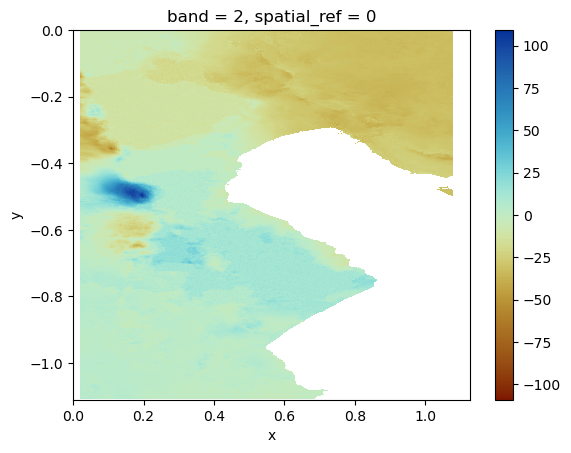

In [14]:
unwrapped_lowres.plot.imshow(cmap=cmap_lin)

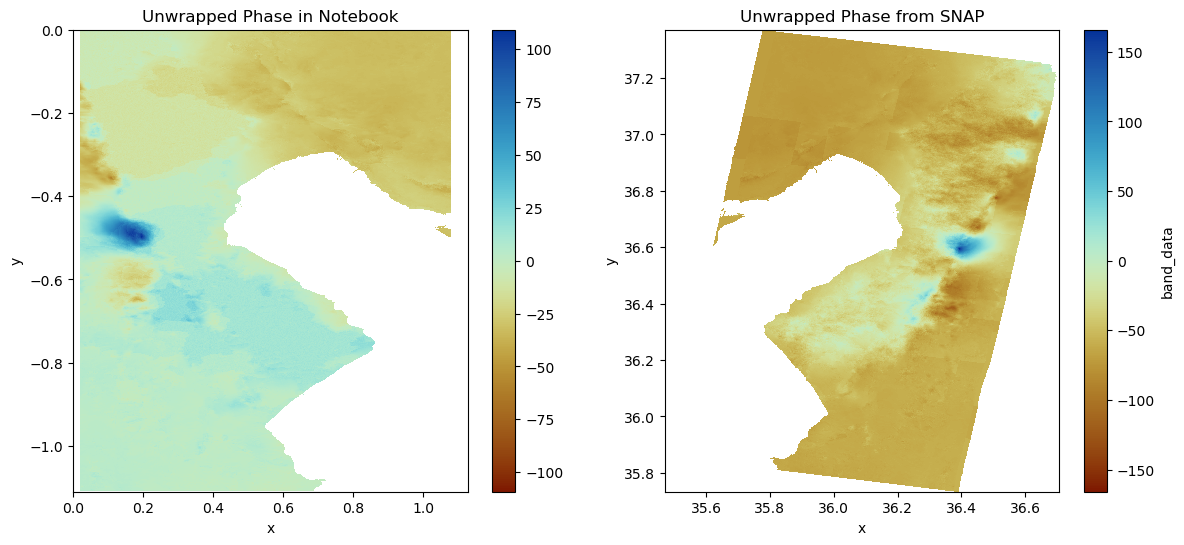

In [18]:
# Plot the unwrapped phase
fig, axs = plt.subplots(1,2, figsize=(14,6))
unwrapped_lowres.plot.imshow(ax=axs[0], cmap=cmap_lin).axes.set_title("Unwrapped Phase in Notebook")
lowcoh.squeeze().where(lowcoh.squeeze() != 0).plot.imshow(ax=axs[1], cmap=cmap_lin).axes.set_title("Unwrapped Phase from SNAP")
plt.show()